# Phylogenetic signals

Test grass vs dicot; myc vs non-myc dicot; panicoide vs chloridoideae and maize vs sorghum

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(DESeq2)
library(phyloseq)
library(doParallel)



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Formula

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘Hmisc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: 

# Load phyloseq object and trim to responders

In [48]:
%%R
log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')

physeq.Full = readRDS(F)

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 
l2f = l2f[l2f$p.adj < .05,]
resp = l2f.sig$OTU %>% unique %>% as.character
l2f = NULL

phy = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
phy = prune_taxa(resp, phy)
phy = subset_samples(phy, Plant != "BARE")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


In [49]:
%%R
sample_data(phy)[,c("Plant", "Subfamily")] 

Sample Data:        [174 samples by 2 sample variables]:
                   Plant     Subfamily
sample5-1.22_Nneg 75-062      Paniceae
sample6-4.12_Npos   Oh7B      Paniceae
sample4-1.03_Npos  SETFA      Paniceae
sample5-2.06_Npos   MS71      Paniceae
sample5-4.08_Npos   MS71      Paniceae
sample5-4.28_Npos 75-062      Paniceae
sample5-1.29_Npos  ERATE Andropogoneae
sample4-2.02_Nneg  SETFA      Paniceae
sample4-4.21_Nneg  SETFA      Paniceae
sample6-2.13_Npos   Oh7B      Paniceae
sample5-2.29_Nneg 75-062      Paniceae
sample5-2.06_Nneg   MS71      Paniceae
sample1-2.23_Nneg  FAGES          <NA>
sample6-2.26_Nneg    B73      Paniceae
sample6-3.18_Nneg    B73      Paniceae
sample5-3.13_Nneg   MS71      Paniceae
sample2-2.08_Nneg  AMAPO          <NA>
sample5-1.17_Nneg   MS71      Paniceae
sample6-3.01_Npos    B97      Paniceae
sample3-2.03_Nneg  GLYMA          <NA>
sample5-4.08_Nneg   MS71      Paniceae
sample5-4.05_Npos    H99      Paniceae
sample6-2.16_Npos    B97      Paniceae
sample1

# OTUs enriched in the poaceae 

## Data wrangling for poaceae analysis

In [50]:
%%R
# add family and subfamily
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
Family = c("Poaceae", "Asteraceae", "Poaceae", "Polygonaceae", "Amaranthaceae", "Poaceae", "Poaceae",
               "Poaceae", "Poaceae", "Malvaceae", "Poaceae", "Fabaceae", "Poaceae", "Poaceae", "Poaceae", "Poaceae", "Poaceae",
               "Poaceae", "Poaceae", "Poaceae", "Poaceae", "Poaceae")
FM = cbind(Plant, Family) %>% as.data.frame
FM %>% print
sd = as(sample_data(phy), "data.frame")
sd = left_join(sd, FM, by = "Plant")
rownames(sd) = sd$X.sample
head(sd)

    Plant        Family
1   ERATE       Poaceae
2   HELAN    Asteraceae
3     B73       Poaceae
4   FAGES  Polygonaceae
5   AMAPO Amaranthaceae
6  SORSUD       Poaceae
7   SORBI       Poaceae
8   ELCOR       Poaceae
9   ECHCG       Poaceae
10  ABUTH     Malvaceae
11  SETFA       Poaceae
12  GLYMA      Fabaceae
13   MS71       Poaceae
14   Mo18       Poaceae
15  Il14H       Poaceae
16  Tx303       Poaceae
17   Oh7B       Poaceae
18    B97       Poaceae
19  Hp301       Poaceae
20 75-062       Poaceae
21    Ki3       Poaceae
22    H99       Poaceae
                           X.sample Library Primer_Plate Primer_Well_ID
sample5-1.22_Nneg sample5-1.22_Nneg       1            1             A4
sample6-4.12_Npos sample6-4.12_Npos       1            2             H3
sample4-1.03_Npos sample4-1.03_Npos       1            1             B3
sample5-2.06_Npos sample5-2.06_Npos       1            2             D1
sample5-4.08_Npos sample5-4.08_Npos       1            2             H1
sample5-4.28_Npo

In [51]:
%%R
sample_data(phy) = sd

In [52]:
%%R
sd %>% group_by(Plant) %>% 
    summarise(Cond = last(Grass_Broad))

# A tibble: 22 x 2
    Plant    Cond
   <fctr>  <fctr>
1  75-062 Monocot
2   ABUTH   Dicot
3   AMAPO   Dicot
4     B73 Monocot
5     B97 Monocot
6   ECHCG Monocot
7   ELCOR Monocot
8   ERATE Monocot
9   FAGES   Dicot
10  GLYMA   Dicot
# ... with 12 more rows


##  Testing grasses against dicots

### subset samples for balance among the poaceae

In [53]:
%%R
sample_data(phy)$Type %>% levels

[1] "C4_Grass"  "Dicot-Myc" "Dicot-NM"  "Legume"    "Maize"    


In [54]:
%%R
phy.p = subset_samples(phy, Plant %in% c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "Mo18") & Treatment == "Nneg")

In [55]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
sample_data(phy.p)$Grass_Broad = relevel(sample_data(phy.p)$Grass_Broad, "Dicot")
dds = phyloseq_to_deseq2(phy.p, ~Library + Grass_Broad)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 84 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"          "Library1"           "Library2"          
[4] "Grass_BroadDicot"   "Grass_BroadMonocot"


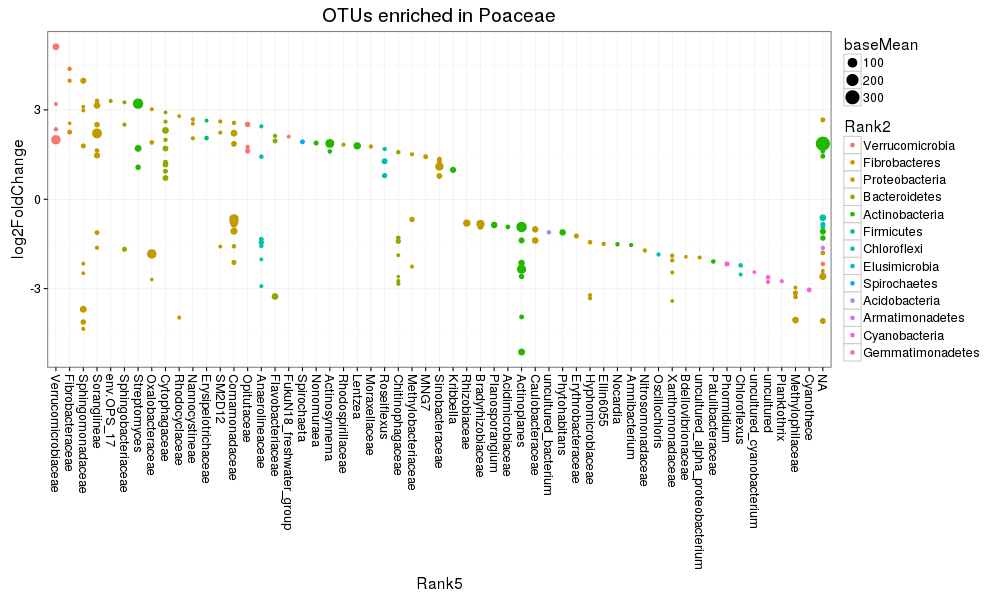

In [56]:
%%R -w 1000 -h 600
sigtab = filter(DF, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Poaceae")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [57]:
%%R
cat(dim(sigtab)[1], "OTUs with poaceae/dicot signal")

174 OTUs with poaceae/dicot signal

# Testing mycorrhizal vs non-mycorrhizal dicots

In [58]:
%%R
sample_data(phy)$Type %>% levels

[1] "C4_Grass"  "Dicot-Myc" "Dicot-NM"  "Legume"    "Maize"    


In [59]:
%%R
phy.p = subset_samples(phy, Type %in% c("Dicot-Myc", "Dicot-NM") & Treatment == "Nneg")

In [60]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
sample_data(phy.p)$Type = relevel(sample_data(phy.p)$Type, "Dicot-Myc")
dds = phyloseq_to_deseq2(phy.p, ~Type)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 37 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"     "TypeDicot.Myc" "TypeDicot.NM" 


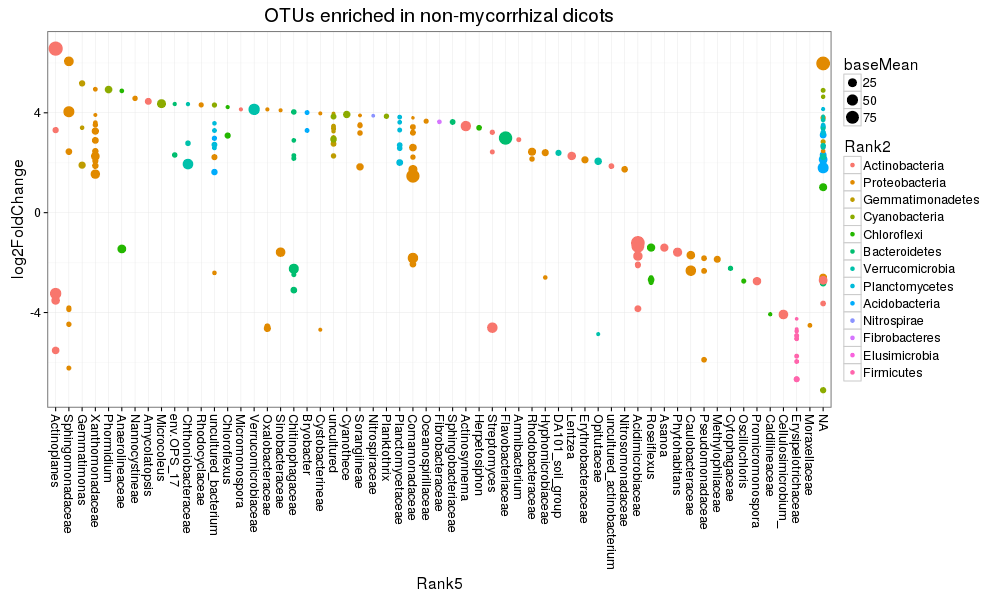

In [61]:
%%R -w 1000 -h 600
sigtab = filter(DF, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in non-mycorrhizal dicots")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# Subfamilies of poaceae

In [62]:
%%R
phy.p = subset_samples(phy, Plant %in% c("ERATE", "SORSUD", 
          "ELCOR", "SETFA", "MS71", "Mo18") & Treatment == "Nneg")

# add family and subfamily
Plant = c("ERATE", "SORSUD", 
          "ELCOR", "SETFA", "MS71", "Mo18")
SubFamily = c("Chloridoideae", "Panicoideae", 
               "Chloridoideae", "Panicoideae", "Panicoideae", "Panicoideae")
SM = cbind(Plant, SubFamily) %>% as.data.frame
SM %>% print
sd = as(sample_data(phy.p), "data.frame")
sd = left_join(sd, SM, by = "Plant")
rownames(sd) = sd$X.sample

sample_data(phy.p) = sd

   Plant     SubFamily
1  ERATE Chloridoideae
2 SORSUD   Panicoideae
3  ELCOR Chloridoideae
4  SETFA   Panicoideae
5   MS71   Panicoideae
6   Mo18   Panicoideae


In [63]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
sample_data(phy.p)$SubFamily = relevel(sample_data(phy.p)$SubFamily, "Chloridoideae")
dds = phyloseq_to_deseq2(phy.p, ~Library + SubFamily)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 46 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"              "Library1"               "Library2"              
[4] "SubFamilyChloridoideae" "SubFamilyPanicoideae"  


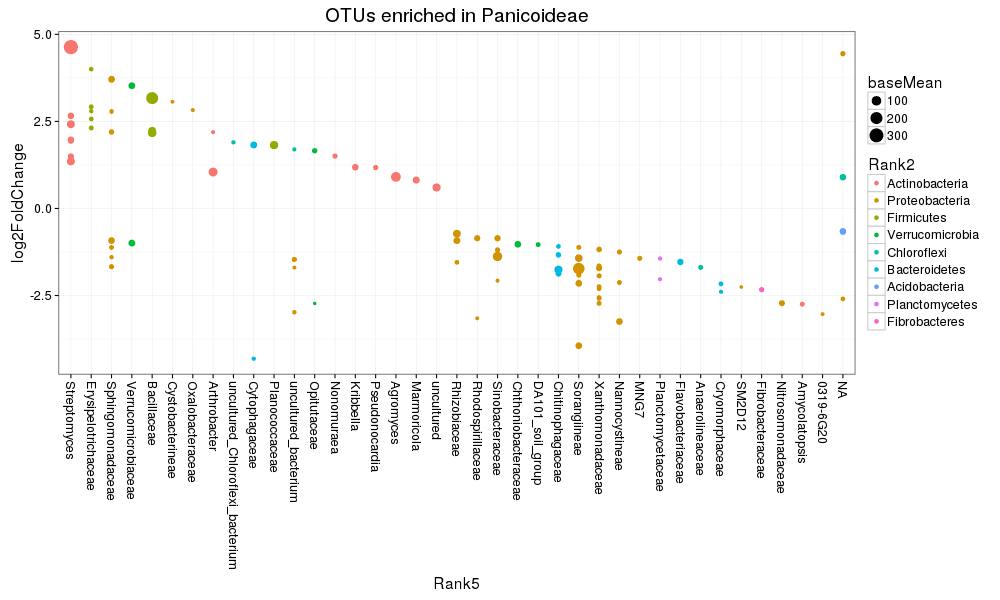

In [64]:
%%R -w 1000 -h 600
sigtab = filter(DF, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Panicoideae")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# Maize vs other panicoideae

In [65]:
%%R
phy.p = subset_samples(phy, Plant %in% c("B73", "SORSUD", "SORBI", 
          "ECHCG", "SETFA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99", "ERATE", "ELCOR") & Treatment == "Nneg")


In [66]:
%%R
sample_data(phy.p)$Type %>% levels


[1] "C4_Grass" "Maize"   


In [67]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
sample_data(phy.p)$Type = relevel(sample_data(phy.p)$Type, "C4_Grass")
dds = phyloseq_to_deseq2(phy.p, ~Library + Type)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 71 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"    "Library1"     "Library2"     "TypeC4_Grass" "TypeMaize"   


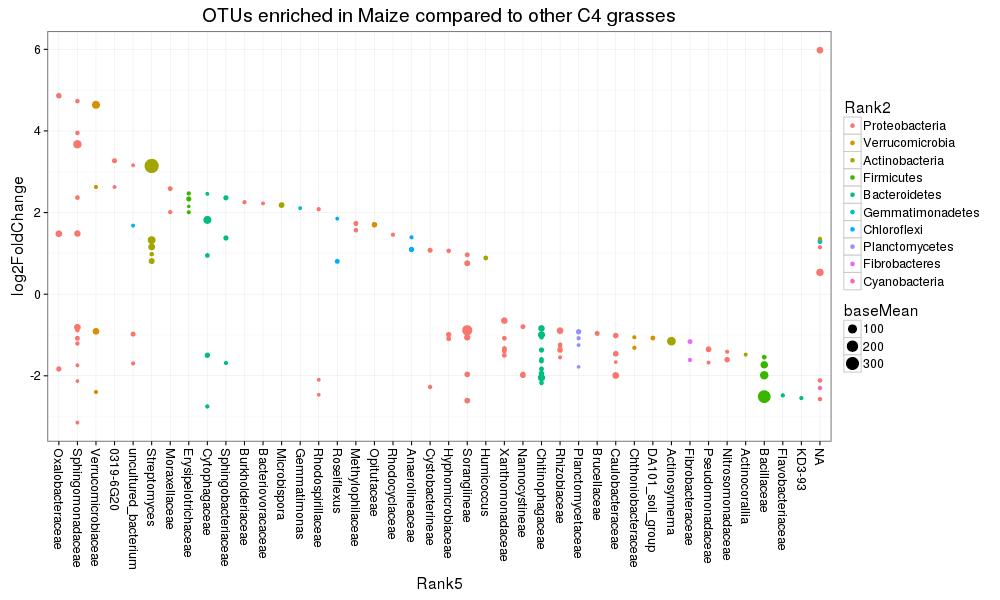

In [68]:
%%R -w 1000 -h 600
sigtab = filter(DF, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Maize compared to other C4 grasses")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# Maize vs sorghum

In [69]:
%%R
phy.p = subset_samples(phy, Plant %in% c("SORSUD", "SORBI",  "Mo18",  "Tx303") & Treatment == "Nneg")


In [70]:
%%R
sample_data(phy.p)$Type %>% levels


[1] "C4_Grass" "Maize"   


In [71]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
sample_data(phy.p)$Type = relevel(sample_data(phy.p)$Type, "C4_Grass")
dds = phyloseq_to_deseq2(phy.p, ~Type)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 25 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"    "TypeC4_Grass" "TypeMaize"   


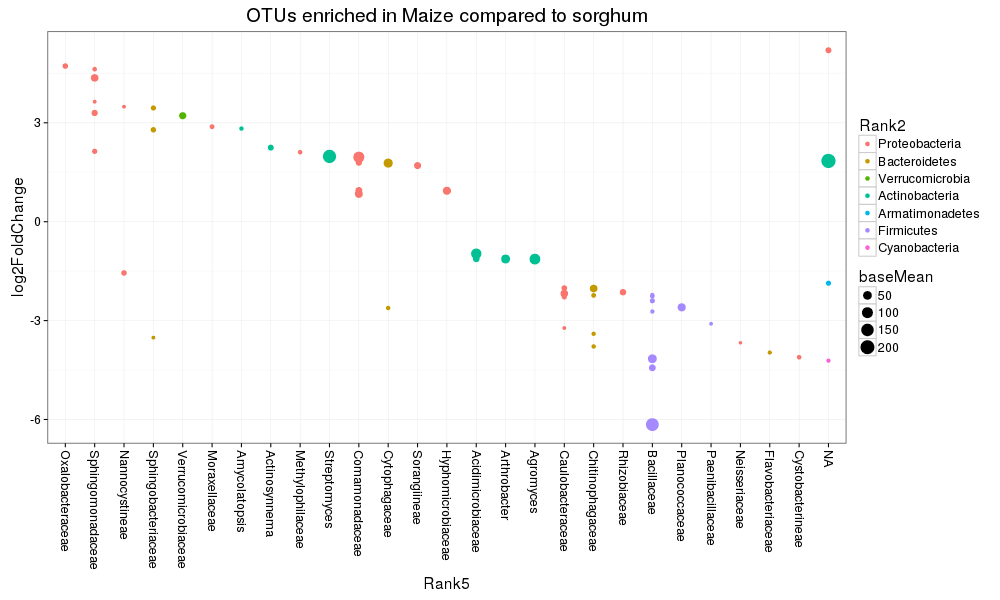

In [72]:
%%R -w 1000 -h 600
sigtab = filter(DF, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Maize compared to sorghum")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x